In [19]:
import os
import pandas as pd
import polars as polars
from tqdm import tqdm
from params import const_en, const_ja
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# train_path = r"\\10.10.20.61\OperatorAssistanceSystem\Patipol\Processed Data Files\2024.06-2025.05"
# test_path = r"\\10.10.20.61\OperatorAssistanceSystem\Patipol\Processed Data Files\202506"
#  # Gets Names of CSV files in list.
# csv_file_train = [f for f in os.listdir(train_path) if f.endswith('.csv')]
# csv_file_test = [f for f in os.listdir(test_path) if f.endswith('.csv')]
val_df = polars.read_csv(("val_df.csv"),low_memory=False) #used
result_tdf = polars.read_csv(("result_tdf.csv"),low_memory=False) #used
train_df = polars.read_csv(("train_df.csv"),low_memory=False) #used
Const = const_en

In [20]:
# Get rid of dupes columns
train_df = train_df.drop([col for col in train_df.columns if col.endswith('.1')])
val_df = val_df.drop([col for col in val_df.columns if col.endswith('.1')])
result_tdf = result_tdf.drop([col for col in result_tdf.columns if col.endswith('.1')])
def cast_columns_to_float(df,cols):
    for col in cols:
        if col in df.columns:
            df = df.with_columns(df[col].cast(polars.Float64).alias(col))
    return df
float_column = [
    Const.V_TARGET_OUTPUT, Const.V_BURNER_OUTPUT, Const.FEEDER1,
    Const.FEEDER2, Const.FEEDER3, Const.FEEDER4, Const.FEEDER5,
    Const.FEEDER6, Const.FEEDER7, Const.FEEDER8, Const.FEEDER9,
    Const.FEEDER10, Const.FEEDER11, Const.FEEDER12, Const.FEEDER13,
    Const.FEEDER14, Const.FEEDER15, Const.FEEDER16, Const.FEEDER17,
    Const.FEEDER18, Const.FEEDER19, Const.FEEDER20, Const.V_SET_TEMP,
    Const.V_AGG_TEMP, Const.V_BAG_TEMP
]
train_df = cast_columns_to_float(train_df, float_column)
val_df = cast_columns_to_float(val_df,float_column)
result_tdf = cast_columns_to_float(result_tdf, float_column)
train_df = train_df.to_pandas()
val_df = val_df.to_pandas()
result_tdf = result_tdf.to_pandas()

In [21]:
time_varying_unknown_reals = [
    Const.V_BAG_TEMP,
    Const.HUMIDITY,
    Const.TEMPERATURE,
    Const.BAG_INLET_TEMP_RISE_RATE,
    Const.V_AGG_TEMP,
    Const.AGG_TEMP_RISE_RATE
    ]
static_reals = [] #"Wetness of material (sand)"
time_varying_known_reals = [
    # "Sin_Hour",
    # "Cos_Hour",
    # "Sin_Month",
    # "Cos_Month",
    Const.TOTAL_SUPPLY,
    Const.FEEDER1,
    Const.V_SET_TEMP,
    Const.FEEDER2,
    Const.FEEDER3,
    Const.FEEDER4,
    Const.FEEDER5,
    Const.FEEDER7,
    Const.SUPPLY_TIME_ELAPSED,
    Const.COLD_AGG_TIME_ELAPSED
]

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = train_df["time_idx"].max() - max_prediction_length

train_df["operation_id"] = train_df["operation_id"].astype(str)
# train_df["subsequence_id"] = train_df["subsequence_id"].astype(str)

val_df["operation_id"] = val_df["operation_id"].astype(str)
# val_df["subsequence_id"] = val_df["subsequence_id"].astype(str)


training = TimeSeriesDataSet(
    train_df, #[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=Const.V_TARGET_OUTPUT,
    group_ids=["operation_id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["operation_id"],
    static_reals=static_reals,
    # time_varying_known_categoricals=["DATE", "TIME"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=list(time_varying_known_reals),
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=list(time_varying_unknown_reals),
    target_normalizer=GroupNormalizer(
        groups=["operation_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders = {
        "operation_id": NaNLabelEncoder(add_nan=True)
        # "subsequence_id": NaNLabelEncoder(add_nan=True),
    # Include all other categorical columns used
    },
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\data\encoders.py:401: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


In [24]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


tensor(0.)

In [25]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Adam"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.0k


c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]
Learning rate set to 0.00020417379446695298
Restoring states from the checkpoint path a

suggested learning rate: 0.00020417379446695298


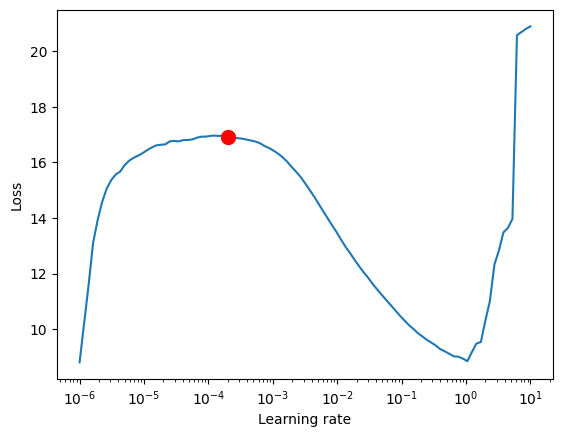

C:\Users\3562\AppData\Local\Temp\ipykernel_33464\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [26]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [27]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [28]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger(save_dir=os.getcwd(), name="logs_csv")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 36.2k


c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [29]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 780    | train
3  | prescalers                         | ModuleDict                      | 320    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s, v_num=2, train_loss_step=0.928, val_loss=6.250, train_loss_epoch=0.970]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s, v_num=2, train_loss_step=0.928, val_loss=6.250, train_loss_epoch=0.970]


In [30]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import optuna
import statsmodels
print(optuna.__version__)
print(statsmodels.__version__)
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-09-16 12:06:53,376] A new study created in memory with name: no-name-f8b5d178-3170-414d-ae98-a38438946039
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),


4.5.0
0.14.5


c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:222: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.hparams.learning_rate = trial.suggest_loguniform(
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:701: Checkpoint directory C:\Users\3562\Documents\TFT_TEST\new_TFT\optuna_test\trial_0 exists and is not empty.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-09-16 12:11:18,668] Trial 0 finished with value: 5

{'gradient_clip_val': 0.3774037122981442, 'hidden_size': 37, 'dropout': 0.19955715088017745, 'hidden_continuous_size': 22, 'attention_head_size': 2, 'learning_rate': 0.002444275246952026}


In [31]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [32]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


tensor(7.3733)

In [33]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [44]:
print("Validation dataset length:", len(validation))
print("Operation IDs in val:", val_df['operation_id'].unique())
print("Time steps per operation_id:")
print(val_df.groupby('operation_id')['time_idx'].max())

Validation dataset length: 2
Operation IDs in val: ['1' '2']
Time steps per operation_id:
operation_id
1    198
2    141
Name: time_idx, dtype: int64


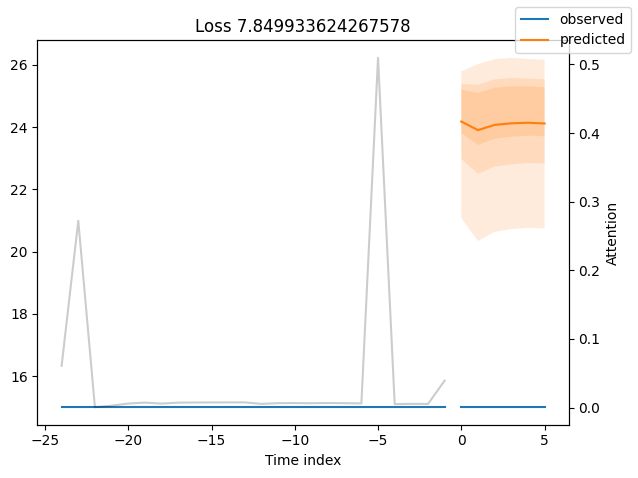

In [42]:
num_predictions = len(raw_predictions.output)
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


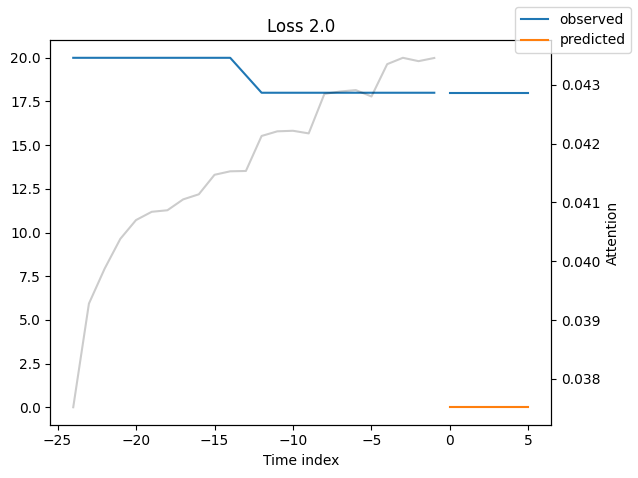

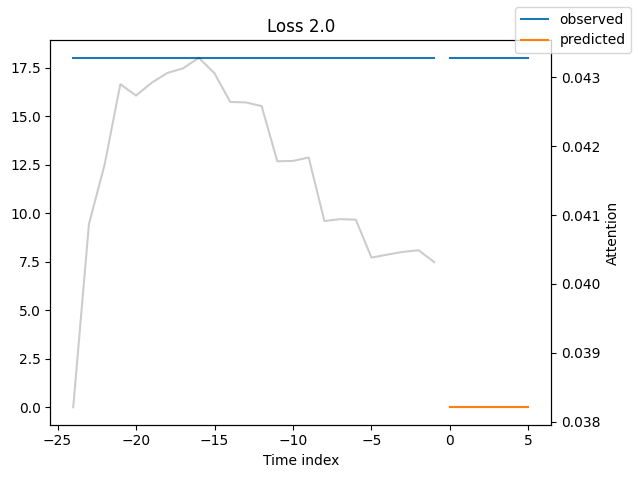

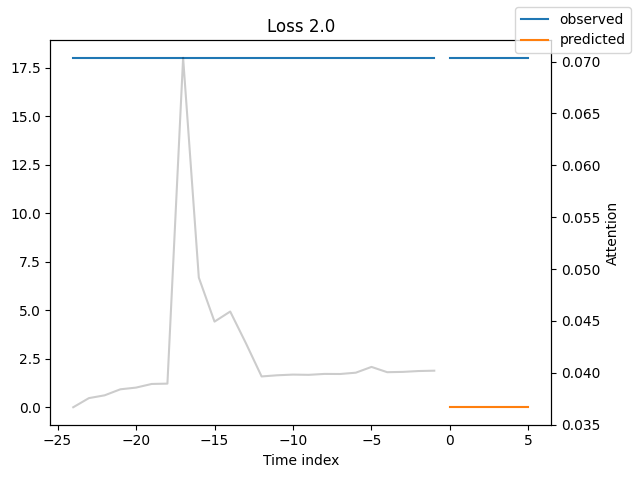

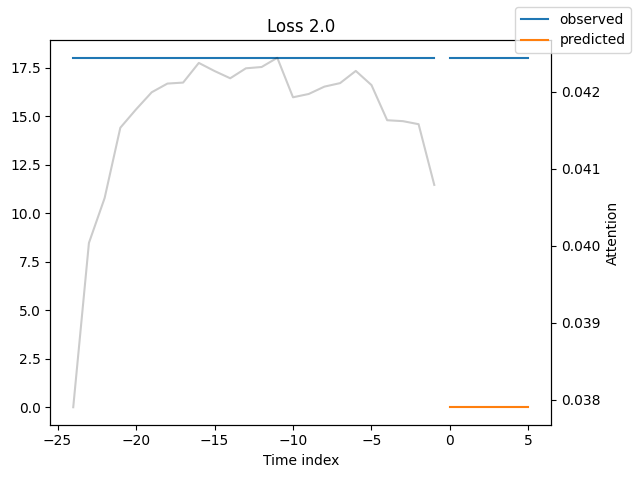

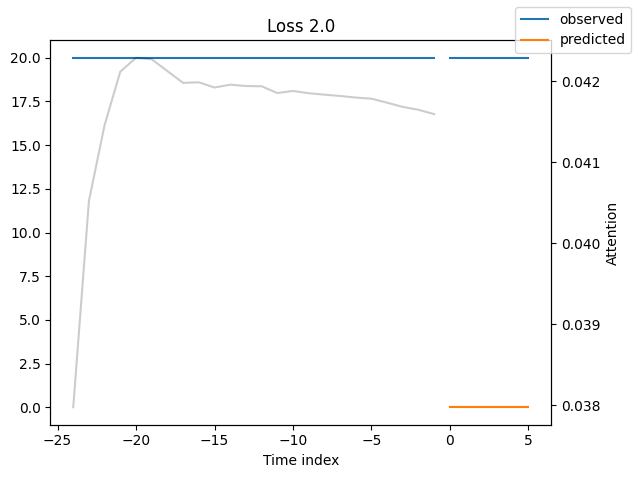

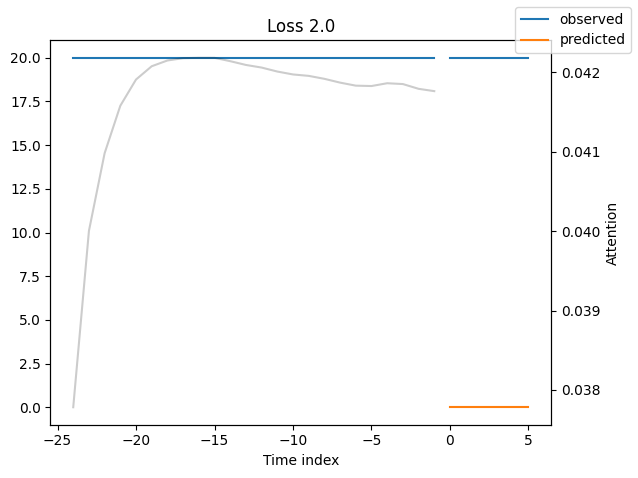

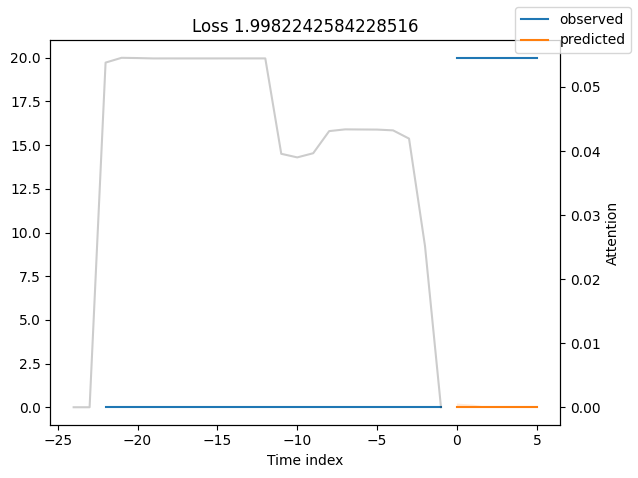

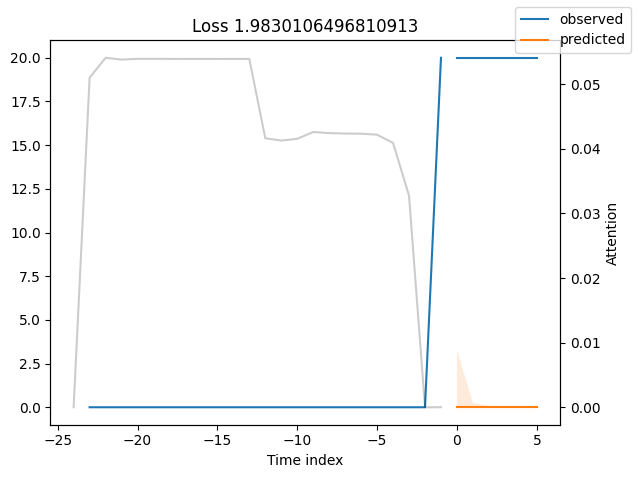

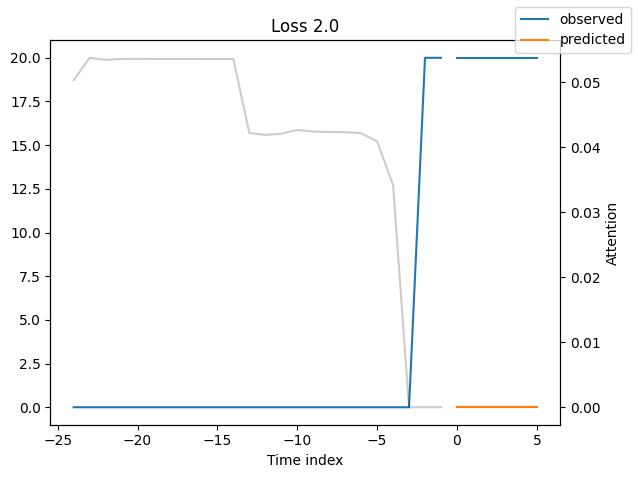

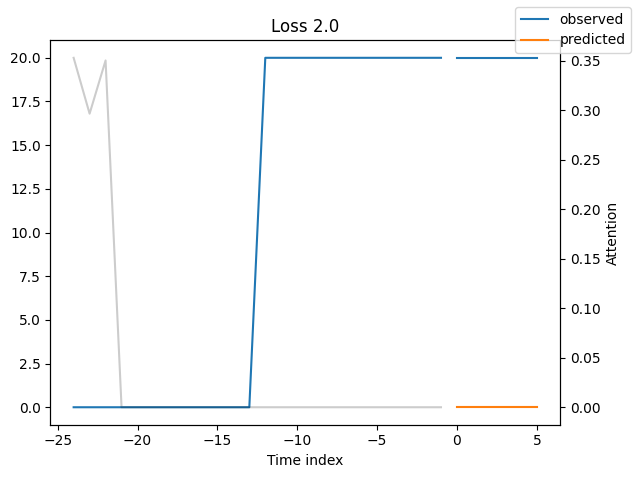

In [ ]:


# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\base\_base_model.py:2218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Target_Output_center': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Target_Output_scale': <Figure size 1000x500 with 2 Axes>,
 'Total_Supply': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder1': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Set_Temperature': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder2': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder3': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder4': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder5': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Supply_Feeder7': <Figure size 1000x500 with 2 Axes>,
 'Supply_Time_Elapsed': <Figure size 1000x500 with 2 Axes>,
 'Cold_Aggregate_Time_Elapsed': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'V_Burner_Bag_Inlet_Temperature': <Figure size 1000x500 with 2 Axes>,
 'Ambient_Humidity': <Figure size 1000x500 with

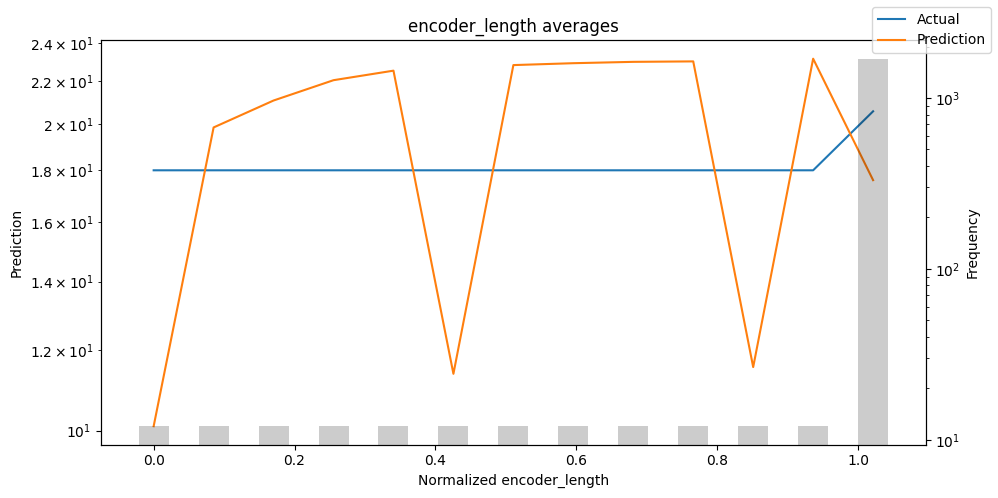

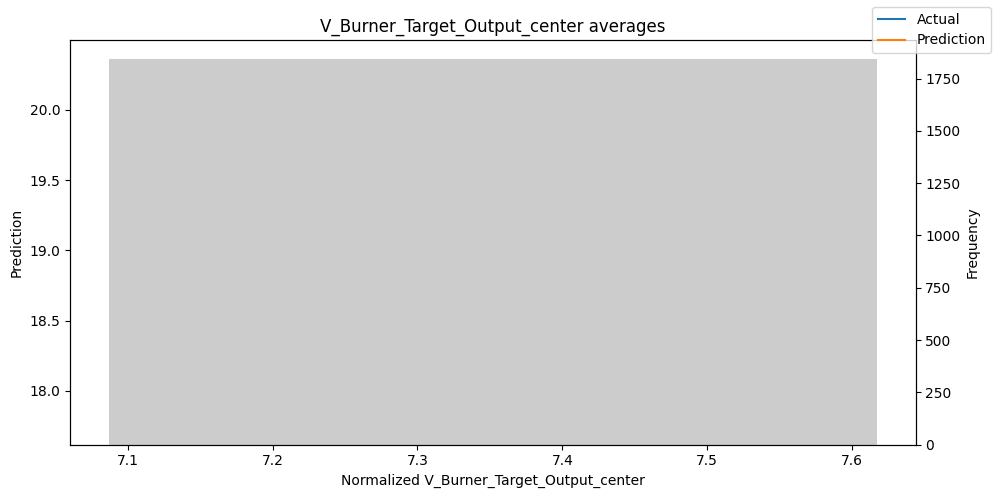

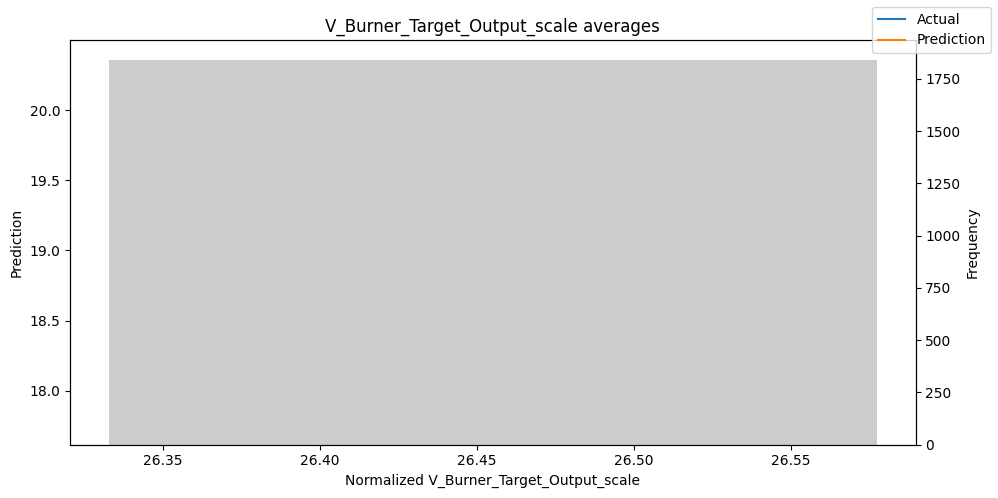

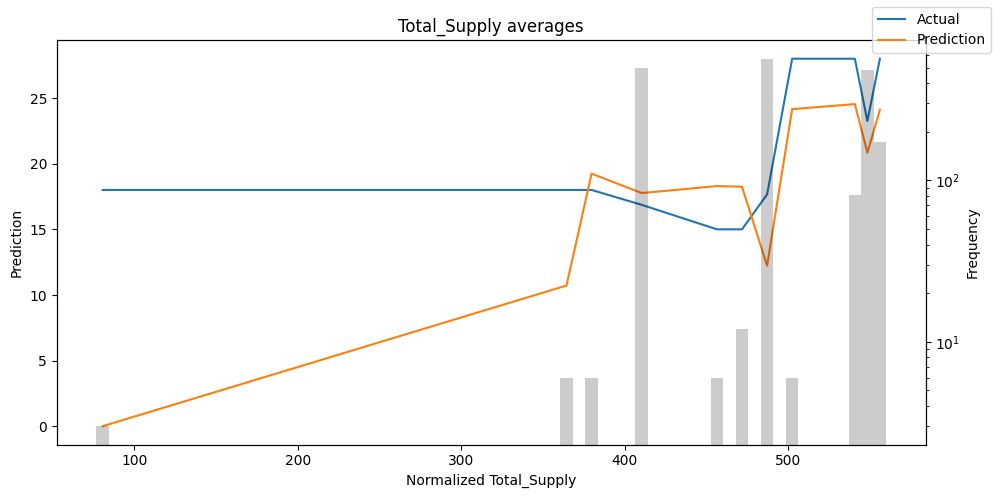

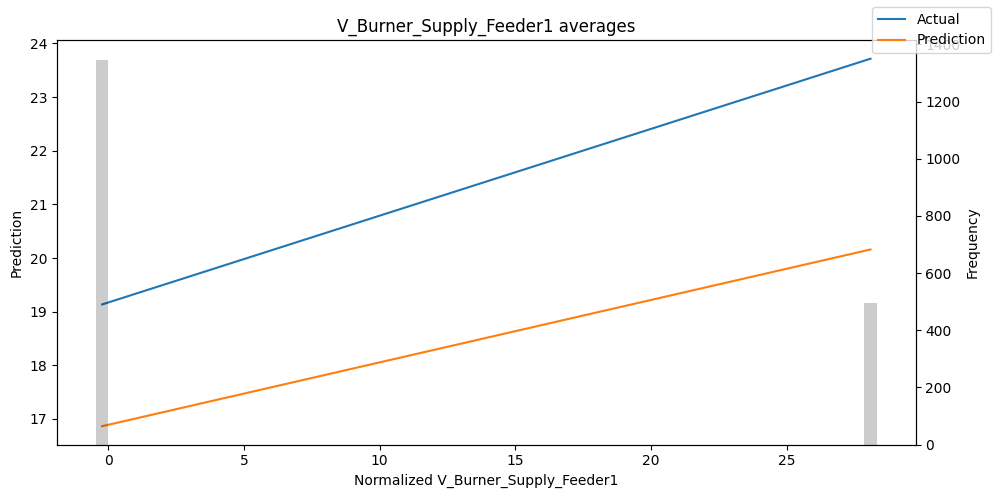

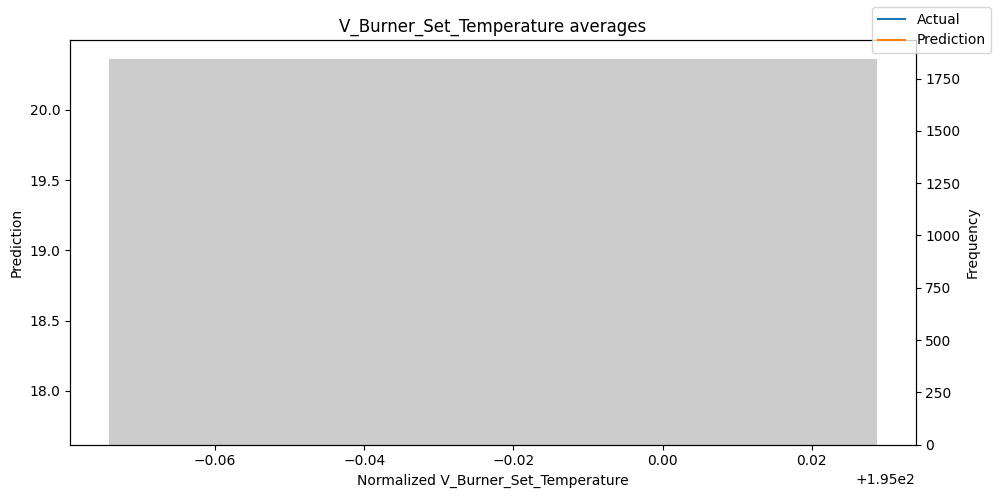

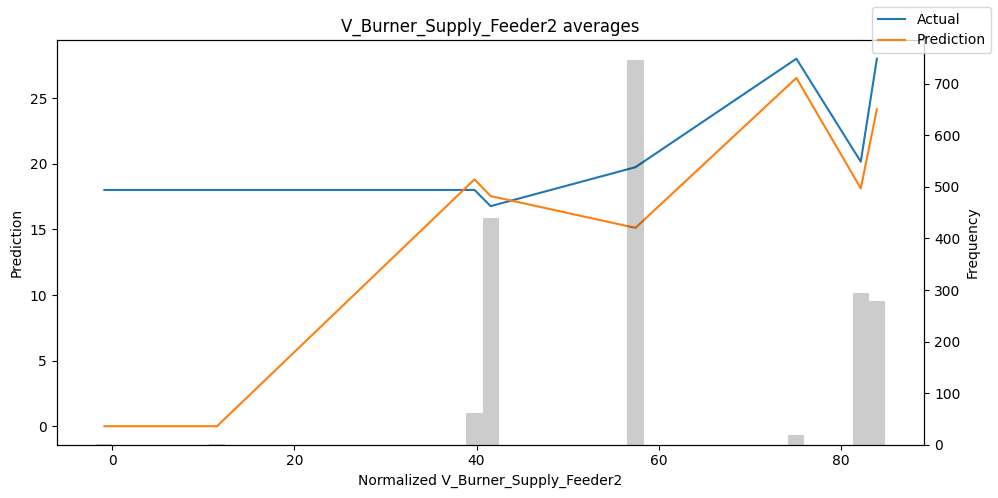

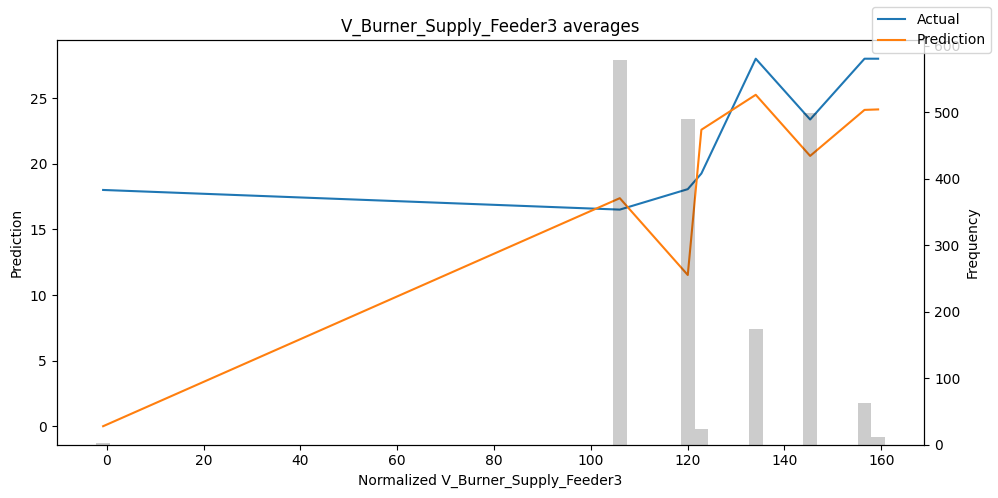

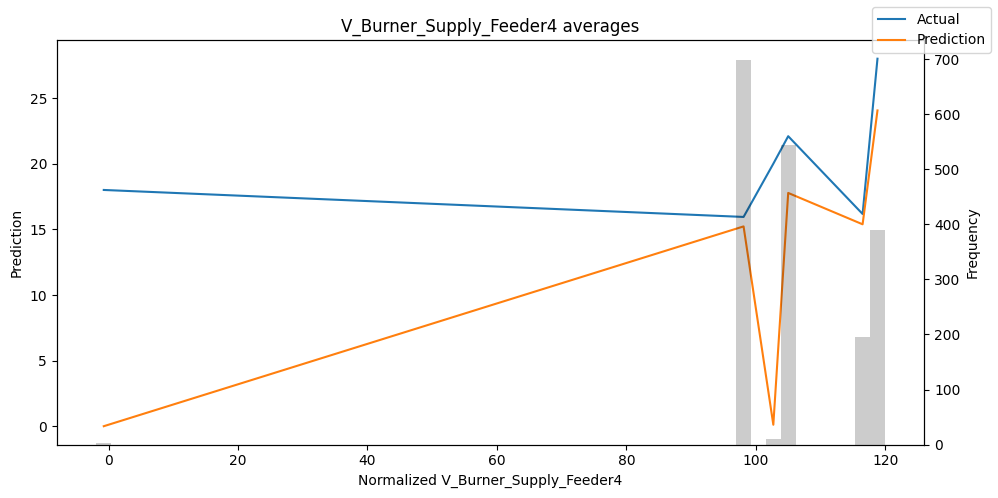

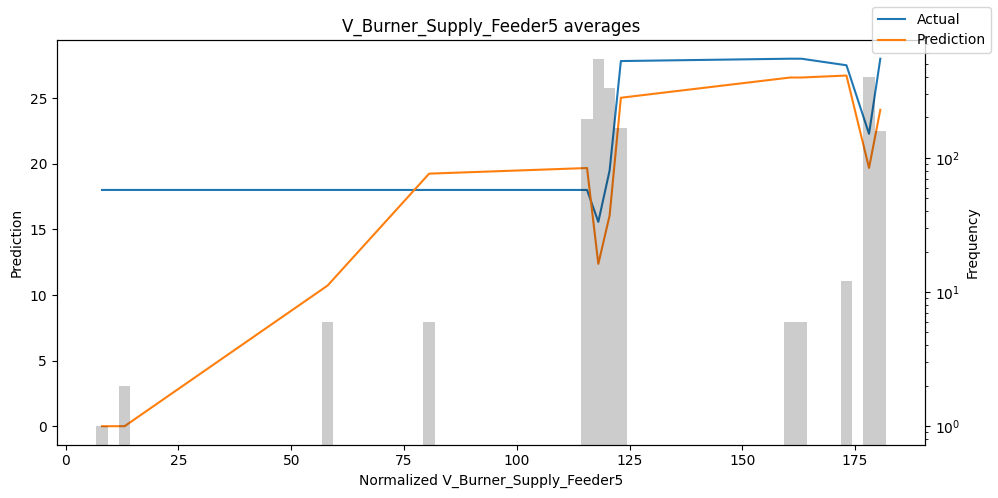

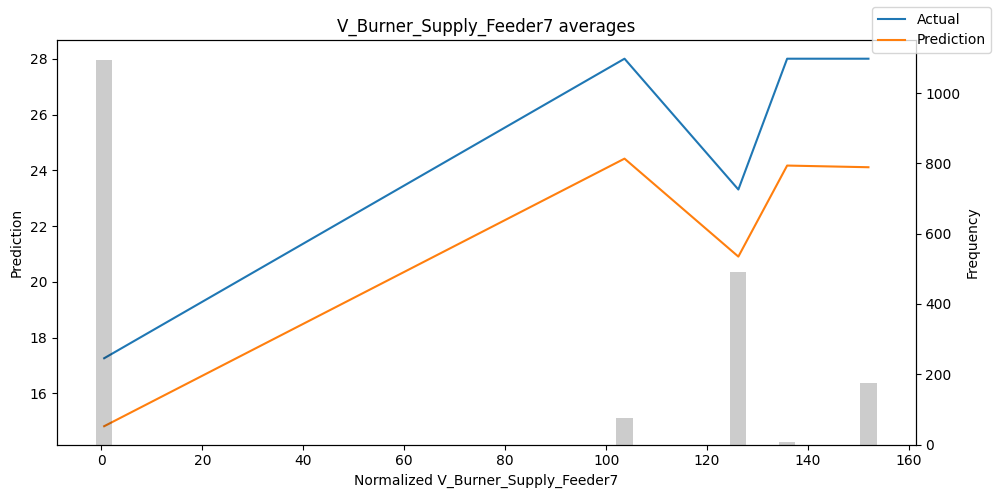

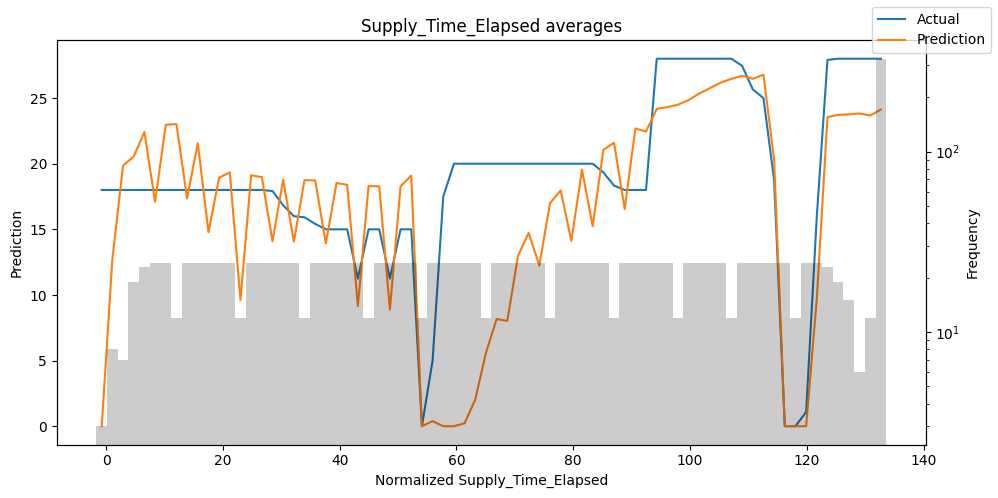

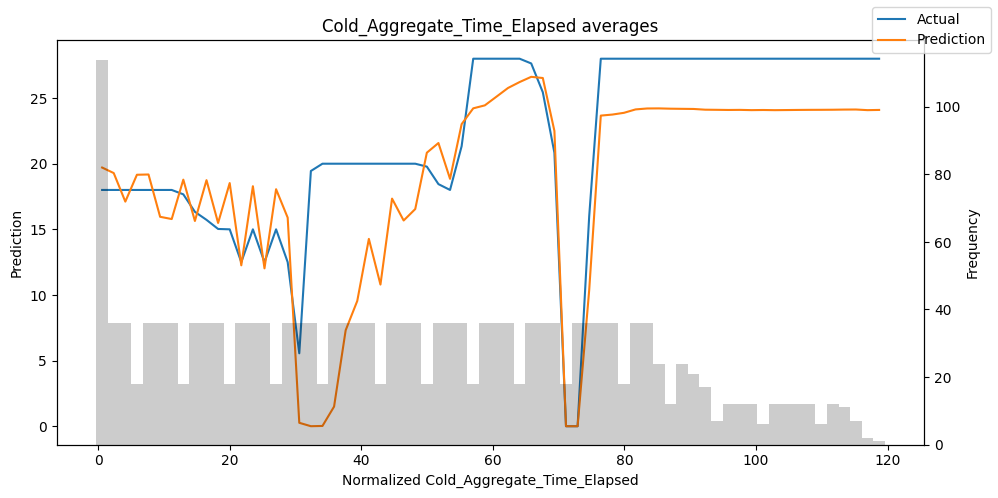

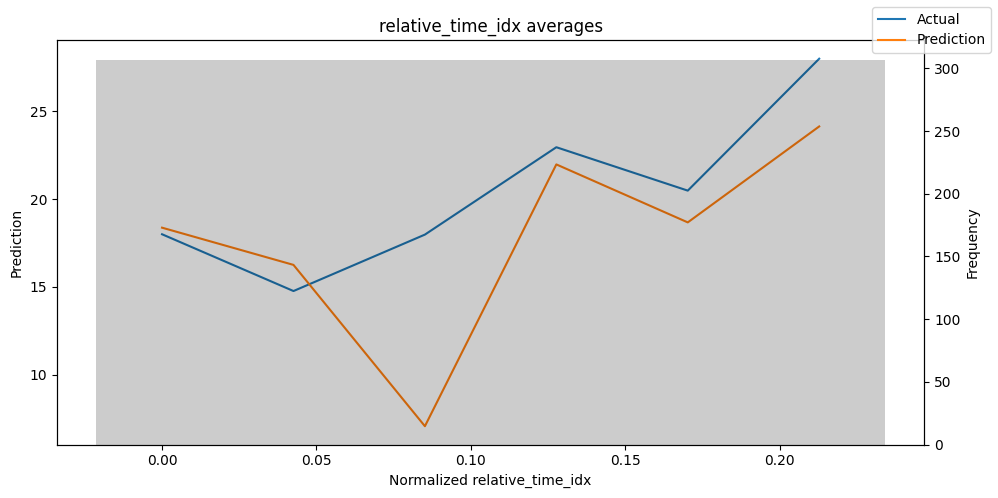

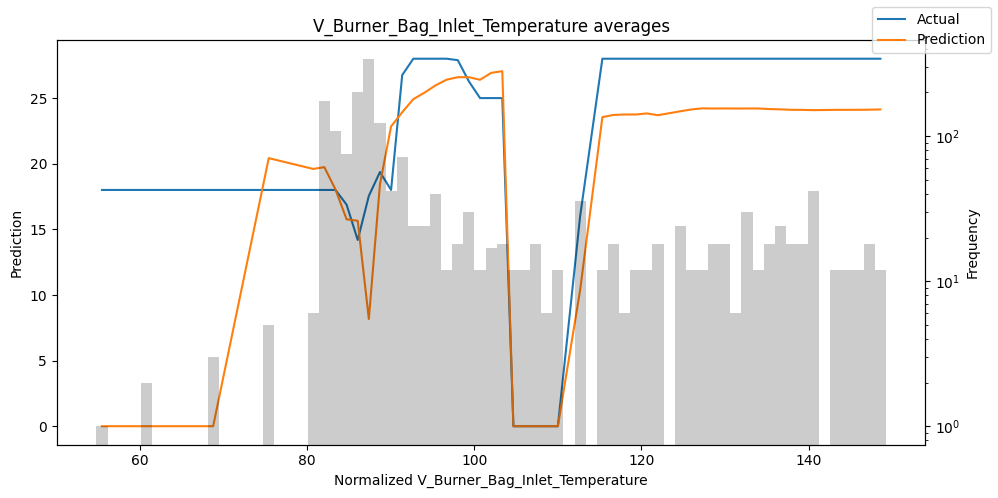

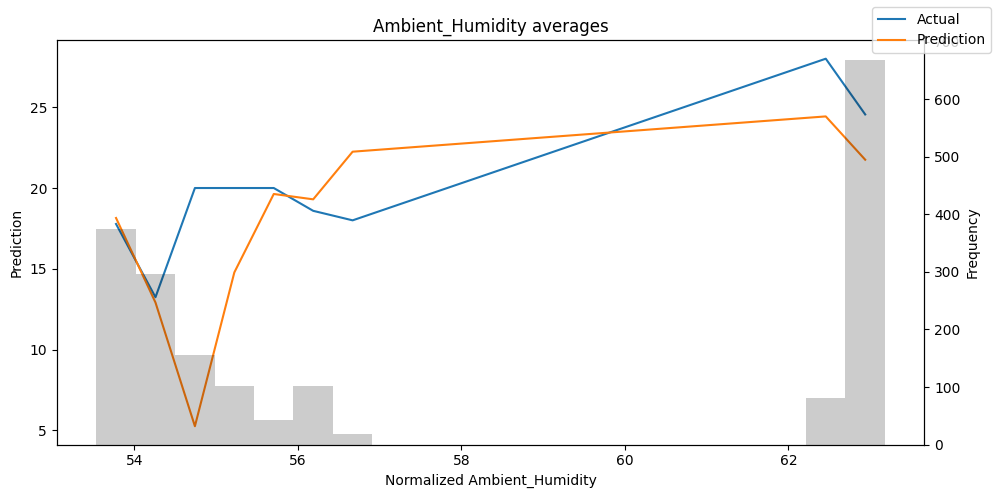

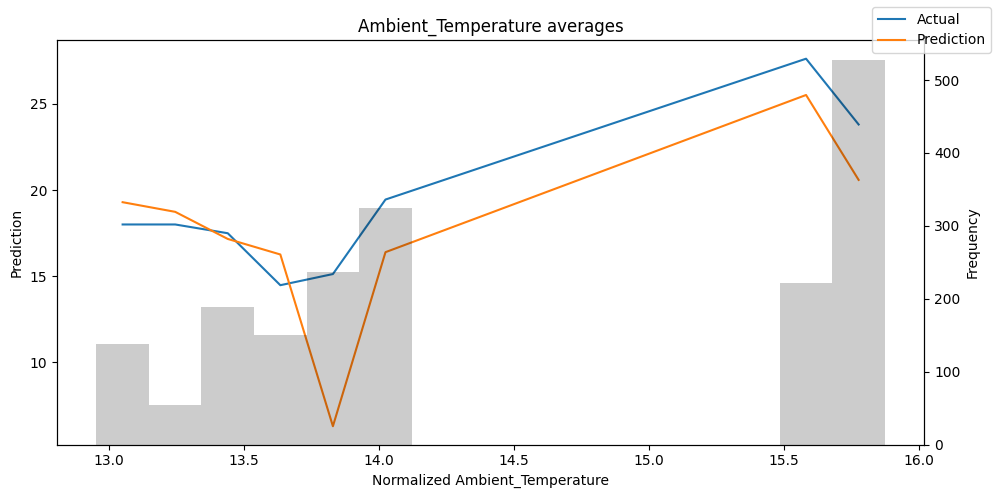

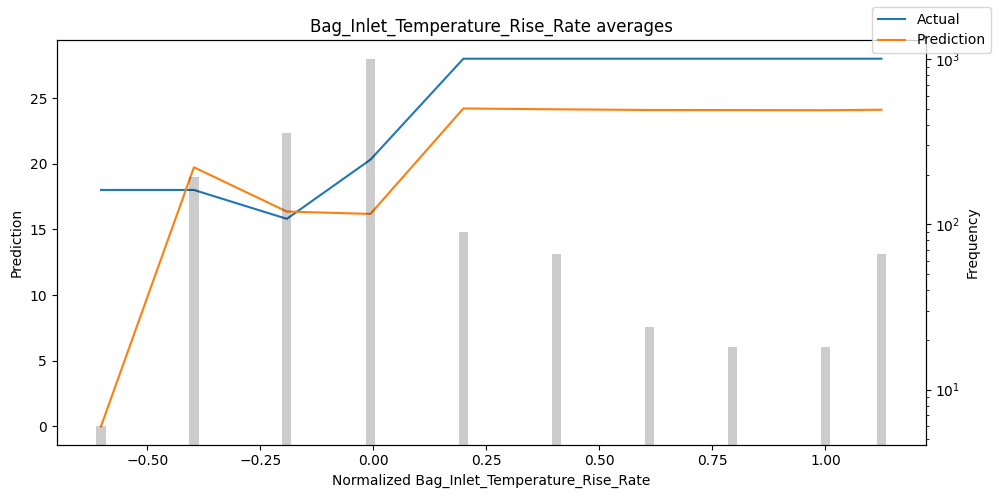

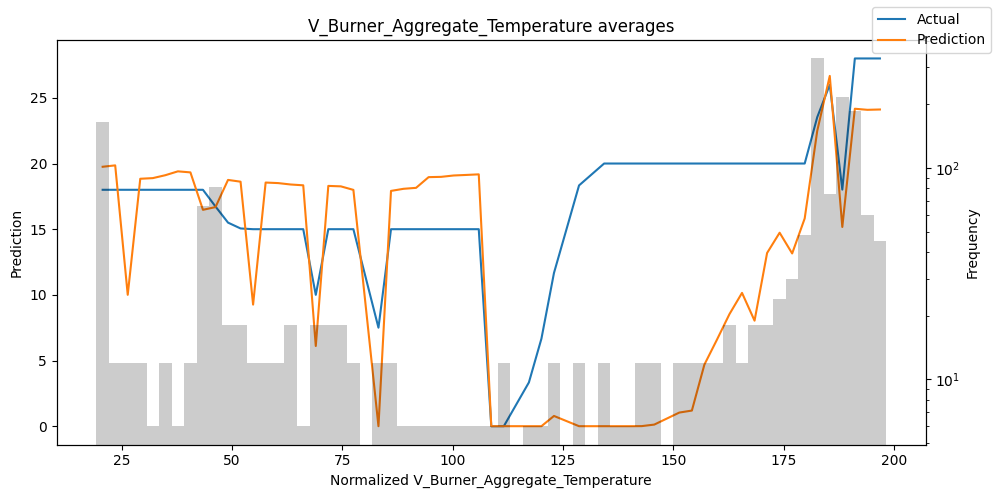

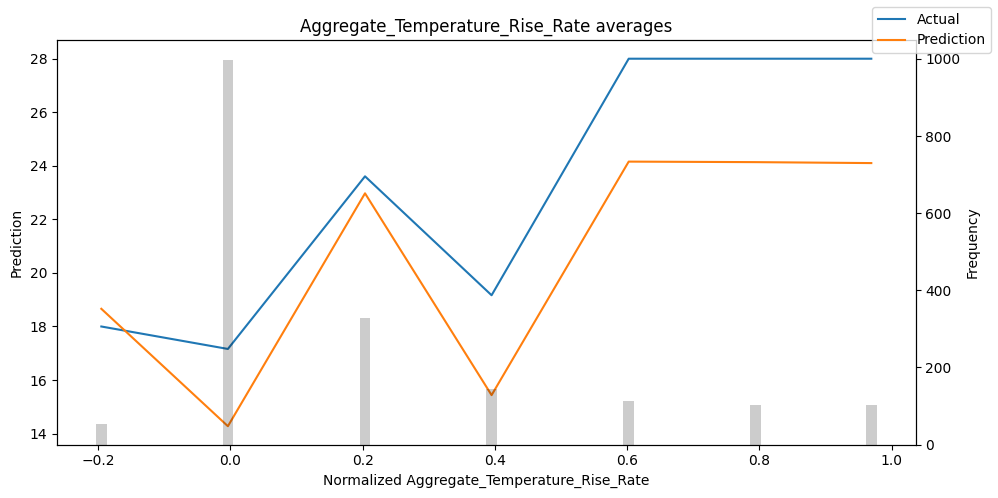

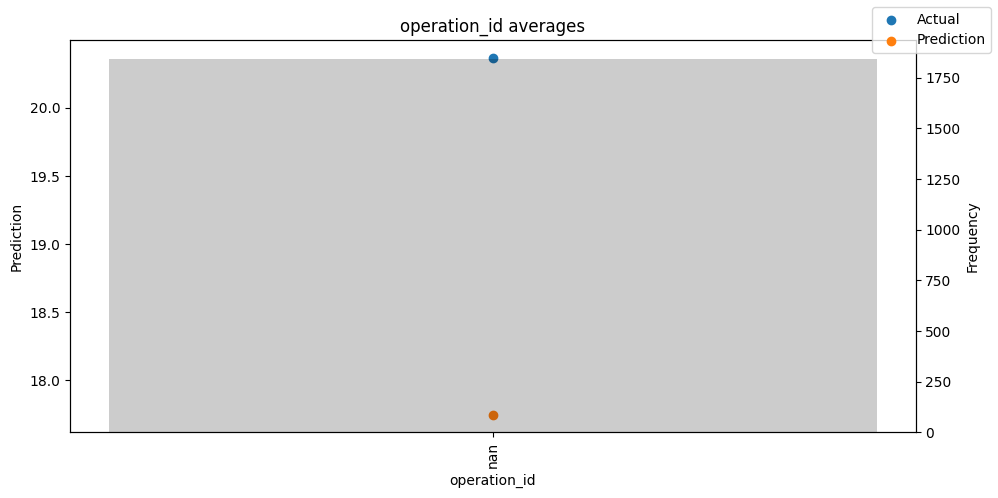

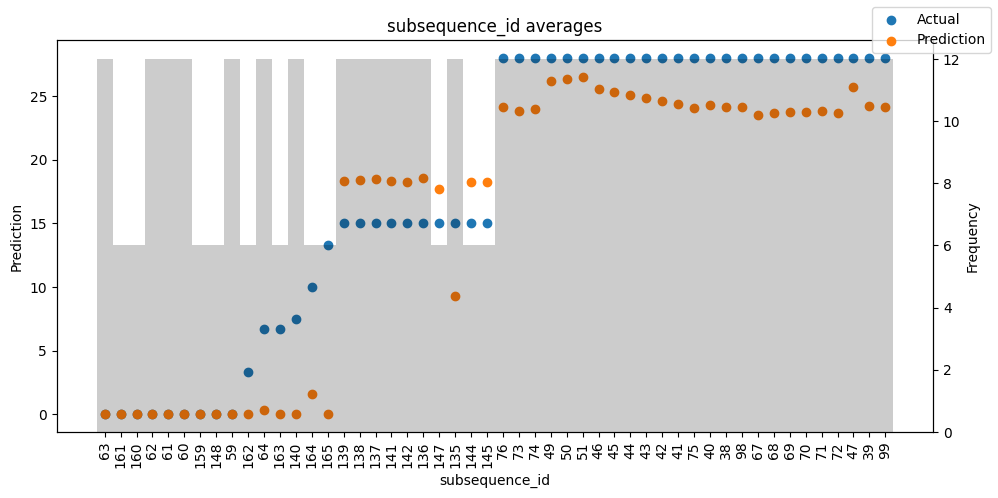

In [ ]:


predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

